## Variance by month of factors affecting growth rate
This notebook calculates the variance of light limitation factor and the temperature factor in the calculation of phytoplankton growth rate in an ESM2M piControl simulation. It saves the output to a netcdf file. The latter part of the notebook loads this netcdf file and plots the variances.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from dask.diagnostics import ProgressBar

In [2]:
basedir = '/local/projects/so_predict_additional/esm2m_froelicher/pi_control/'

In [3]:
variables = ['irrlim_Lg','irrlim_Sm','temp','jprod_nsm','jprod_nLg']

In [4]:
ds = xr.Dataset()
for variable in variables:
    print(variable)
    filename = variable+'_*'
    tmp = xr.open_mfdataset(basedir+filename)
    if variable == 'temp':
        tmp = tmp.sel(st_ocean_sub01=slice(0,105)).rename({'st_ocean_sub01':'st_ocean_sub02'})
    ds[variable] = tmp[variable]

irrlim_Lg
irrlim_Sm
temp
jprod_nsm
jprod_nLg


In [5]:
ds_SOs = ds.isel(st_ocean_sub02=0).where(ds['geolat_t']<-55).chunk({'time':'auto'})
ds_SOs

<xarray.Dataset>
Dimensions:         (time: 6000, xt_ocean: 360, yt_ocean: 200)
Coordinates:
  * time            (time) object 2361-01-16 12:00:00 ... 2860-12-16 12:00:00
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    st_ocean_sub02  float64 5.0
Dimensions without coordinates: xt_ocean, yt_ocean
Data variables:
    irrlim_Lg       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>
    irrlim_Sm       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>
    temp            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>
    jprod_nsm       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>
    jprod_nLg       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>

In [6]:
ds_SOs_monthlymean = ds_SOs.groupby('time.month').mean()
ds_SOs_monthlyvariance = (ds_SOs.groupby('time.month').std()**2)

In [7]:
ds_SOs_monthlyvariance['etemp_normalized'] = ((np.exp(0.063*ds_SOs['temp'])).groupby('time.month')
                                               /np.exp(0.063*ds_SOs_monthlymean['temp'])
                                             ).groupby('time.month').std()**2
ds_SOs_monthlyvariance = ds_SOs_monthlyvariance.chunk({'month':'auto'})

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 36 times more chunks
  return self.array[key]


In [8]:
ds_SOs_monthlyvariance

<xarray.Dataset>
Dimensions:           (month: 12, xt_ocean: 360, yt_ocean: 200)
Coordinates:
    geolon_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolat_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    st_ocean_sub02    float64 5.0
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: xt_ocean, yt_ocean
Data variables:
    irrlim_Lg         (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    irrlim_Sm         (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    temp              (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    jprod_nsm         (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    jprod_nLg         (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    etemp_normalized  (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>

In [9]:
with ProgressBar():
    ds_SOs_monthlyvariance = ds_SOs_monthlyvariance.compute()
    ds_SOs_monthlymean = ds_SOs_monthlymean.compute()
ds_SOs_monthlyvariance.to_netcdf('ds_SOs_monthlyvariance.nc')
ds_SOs_monthlymean.to_netcdf('ds_SOs_monthlymean.nc')

[#################                       ] | 42% Completed |  1min 54.0s

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 12.4s
[########################################] | 100% Completed |  3min 36.6s


### Load and plot variances

In [20]:
ds_var = xr.open_dataset('ds_SOs_monthlyvariance.nc')
ds_mean = xr.open_dataset('ds_SOs_monthlymean.nc')

<ipython-input-18-27d3f9b24a03>:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[i].pcolormesh(ds_var['geolon_t'],


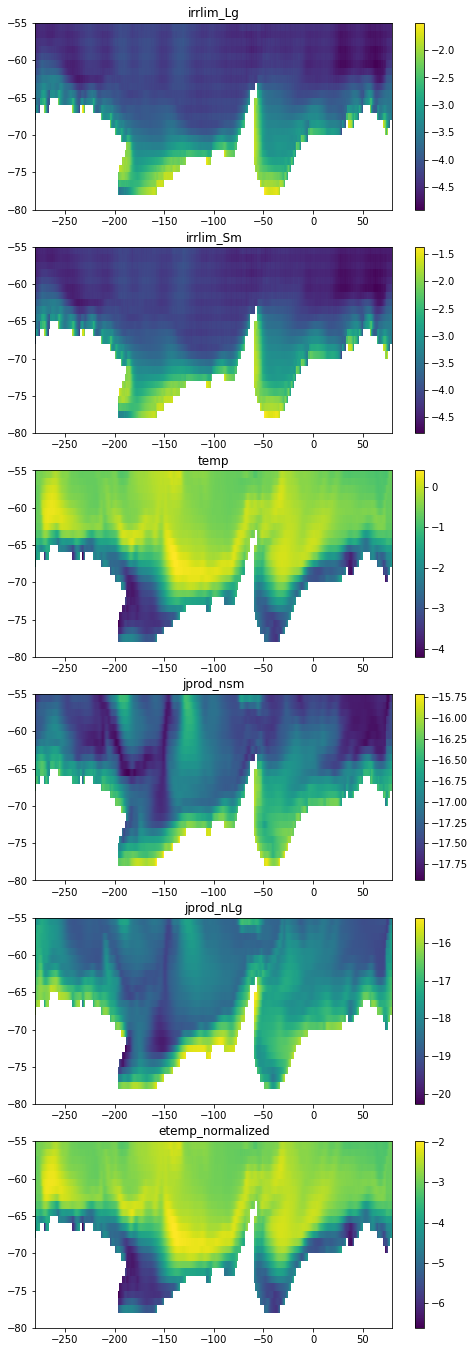

In [18]:
month=11
clims = [-7,-2]
variables = ds_var.data_vars
nv = len(variables)
fig,ax = plt.subplots(figsize=(8,4*nv),nrows=nv)
for i,variable in enumerate(variables):
    im = ax[i].pcolormesh(ds_var['geolon_t'],
                          ds_var['geolat_t'],
                          np.log10(ds_var[variable].sel(month=month)),
                          shading='auto')
    ax[i].set_ylim([-80,-55])
    ax[i].set_title(variable)
#     im.set_clim(clims)
    plt.colorbar(im,ax=ax[i])

<ipython-input-17-ed8c5a64529b>:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[i].pcolormesh(ds_mean['geolon_t'],


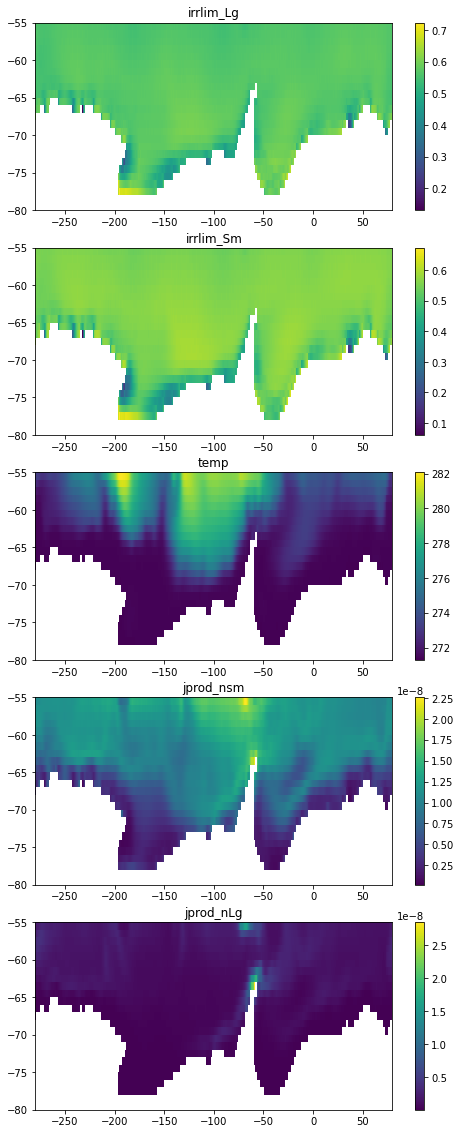

In [17]:
month=10
# clims = [-7,-2]
variables = ds_mean.data_vars
nv = len(variables)
fig,ax = plt.subplots(figsize=(8,4*nv),nrows=nv)
for i,variable in enumerate(variables):
    im = ax[i].pcolormesh(ds_mean['geolon_t'],
                          ds_mean['geolat_t'],
                          ds_mean[variable].sel(month=month),
                          shading='auto')
    ax[i].set_ylim([-80,-55])
    ax[i].set_title(variable)
#     im.set_clim(clims)
    plt.colorbar(im,ax=ax[i])

### Figure for paper supplemental

In [49]:
variables = [['irrlim_Lg','irrlim_Sm','etemp_normalized'],['jprod_nLg','jprod_nsm']]
vardict = {
    'irrlim_Lg':{'clim':[-7,-2],'title':'(a) Light limitation (Large phyto)'},
    'irrlim_Sm':{'clim':[-7,-2],'title':'(b) Light limitation (Small phyto)'},
    'jprod_nLg':{'clim':[-20,-16],'title':'(d) Primary production (Large phyto)'},
    'jprod_nsm':{'clim':[-20,-16],'title':'(e) Primary production (Small phyto)'},
    'etemp_normalized':{'clim':[-7,-2],'title':'(c) Normalized temperature factor for growth rate'}
          }

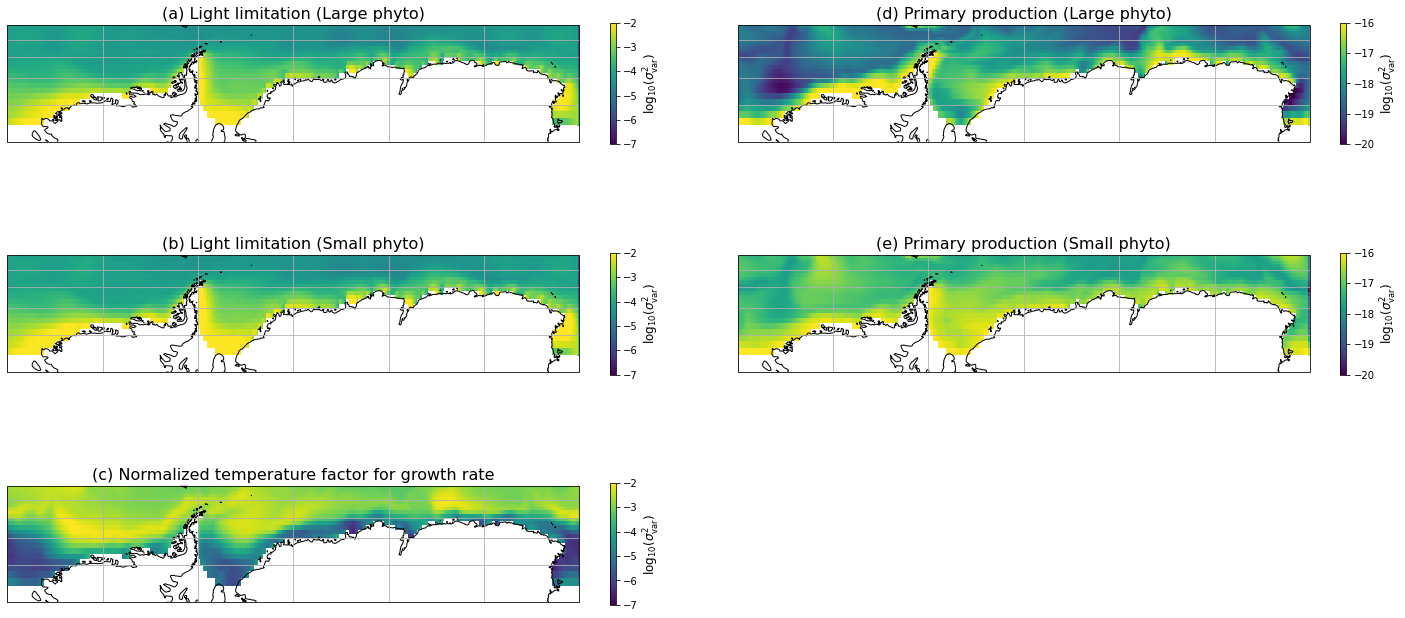

In [64]:
nc = len(variables)
nr = len(variables[0])
fig,ax = plt.subplots(figsize=(24,12),
                      ncols=nc,nrows=nr,
                     subplot_kw={'projection':ccrs.Mercator(max_latitude=-55)})
for c in range(nc):
    for r in range(nr):
        axnow = ax[r,c]
        if (c==1) & (r==2):
            axnow.set_visible(False)
            continue
        varnow = variables[c][r]
        
        axnow.gridlines()
        axnow.coastlines()
        axnow.set_title(vardict[varnow]['title'],fontsize=16)
        
        im = axnow.pcolormesh(ds_var['geolon_t'],
                         ds_var['geolat_t'],
                         np.log10(ds_var[varnow]).sel(month=month),
                         shading='auto',
                         transform=ccrs.PlateCarree())
        im.set_clim(vardict[varnow]['clim'])
        cb = plt.colorbar(im,ax=axnow,orientation='vertical',fraction=0.01)
        cb.set_label(r'$\mathrm{log}_{10}(\sigma_{\mathrm{var}}^2)$',fontsize=12)

fig.savefig('comparison_of_variance.pdf')

## Load and calculate the monthly means of NPP


In [2]:
basedir = '/local/projects/so_predict_additional/esm2m_froelicher/pi_control2/'

In [3]:
variables = ['irrlim_Lg','irrlim_Sm','temp']

In [4]:
ds = xr.Dataset()
for variable in variables:
    print(variable)
    filename = variable+'_*'
    tmp = xr.open_mfdataset(basedir+filename)
    if variable == 'temp':
        tmp = tmp.sel(st_ocean_sub01=slice(0,105)).rename({'st_ocean_sub01':'st_ocean_sub02'})
    ds[variable] = tmp[variable]

irrlim_Lg
irrlim_Sm
temp


In [5]:
ds_SOs = ds.isel(st_ocean_sub02=0).where(ds['geolat_t']<-55).chunk({'time':'auto'})
ds_SOs

<xarray.Dataset>
Dimensions:         (time: 6000, xt_ocean: 360, yt_ocean: 200)
Coordinates:
  * time            (time) object 2361-01-16 12:00:00 ... 2860-12-16 12:00:00
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    st_ocean_sub02  float64 5.0
Dimensions without coordinates: xt_ocean, yt_ocean
Data variables:
    irrlim_Lg       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>
    irrlim_Sm       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>
    temp            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(456, 200, 360), meta=np.ndarray>